In [1]:
import pickle
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger, EarlyStopping
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from scipy.stats import spearmanr
import os
step=4
stack=12
numWindows = int((96-stack)/step)
if ((96-stack)%step > 0):
    numWindows += 1
folderpath      = 'modelcheckpoints/stack'+str(stack)+'step'+str(step)+'/' #for callbacks
X_train = []
X_test = []
y_train = [] 
y_test = []

In [2]:
def getNumpyArray(key):
    dir = "npy/stack"+str(stack)+"step"+str(step)+"/"
    videoName = key + "_all_rgb.npy"
    features = np.array([])
    if (os.path.isfile(dir + 'train/'+ videoName)): 
        features = np.load(dir + 'train/'+ videoName)
    elif (os.path.isfile(dir + 'test/'+ videoName)): 
        features = np.load(dir + 'test/'+ videoName)
    return features

In [3]:
def loadData():
    global X_train, X_test, y_train, y_test
    X_train, y_train = loadDataFromCsv('train.csv')
    X_test, y_test= loadDataFromCsv('test.csv')
    
    print('training samples : ', len(X_train))
    print('testing samples : ', len(X_test))
    
def loadDataFromCsv(filename):
    X = []
    y = []
    scaler = MinMaxScaler()
    
    with open(filename, 'r') as dat:
        lines = dat.readlines()
        count_processed = 0
        for i in range(len(lines)):
            if i > 0: # i==0 is headerline
                line = lines[i]
                tokens = line.split(',')
                if (len(tokens[0]) > 0 and len(tokens[3]) > 0): # tokens[0] is the filename and tokens[3] is the dive score
                    keytokens = tokens[0].split('/')
                    Xdata = getNumpyArray(keytokens[1] +"_"+keytokens[2])
                    if (Xdata.shape==(1, numWindows*1024)):
                        X.append(Xdata.reshape(numWindows*1024))
                        divescore = float(tokens[3])
                        y.append(divescore)
                        count_processed+=1
    X = np.array(X)
    y = scaler.fit_transform(np.array(y).reshape(count_processed,1)).reshape(count_processed,)
    print(X.shape)
    return X, y

loadData()

(1774, 21504)
(444, 21504)
training samples :  1774
testing samples :  444


In [4]:
#layers = [('Input', dim), ('Dense', nn), ('Dropout',rate), ...]
def createModel(modelname, layers, learning_rate):
    opt = optimizers.SGD(learning_rate=learning_rate)
    model = keras.Sequential()
    for i in range(len(layers)):
        layerInfo = layers[i]
        layerType = layerInfo[0]
        layerParam = layerInfo[1]
        if (i==len(layers)-1):
            model.add(keras.layers.Dense(1, activation='sigmoid'))
        else:
            model.add(constructLayer(layerType, layerParam))
            
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()
    return model

def constructLayer(layerType, layerParam):
    if (layerType=='Input'):
        return keras.layers.Input(layerParam)
    elif(layerType=='Dense'):
        return keras.layers.Dense(layerParam, activation='relu')
    elif(layerType=='Dropout'):
        return keras.layers.Dropout(layerParam)
    else:
        return None

In [5]:
def createCallbacks(modelname):
    filepath        = folderpath + modelname + ".hdf5"
    checkpoint      = ModelCheckpoint(filepath, 
                                      monitor='loss', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      mode='max')

    csv_logger      = CSVLogger(folderpath+modelname +'.csv')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list  = [checkpoint,csv_logger, es]
    
    print("Callbacks created:")
    print(callbacks_list[0])
    print(callbacks_list[1])
    print('')
    print("Path to model:", filepath)
    print("Path to log:  ", folderpath+modelname+'.csv')
    return callbacks_list

In [6]:
def trainModel(modelname, model):
    np.random.seed(1)
    tf.random.set_seed(1)
    
    callbacks_list = createCallbacks(modelname)
    history = model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=500,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=callbacks_list
    )


In [7]:
def showResult(modelnames):
    cached_val_loss = {}

    for modelname in modelnames:
        records     = pd.read_csv(folderpath+modelname +'.csv')
        plt.figure(figsize=(6,4))
        #plt.subplot(plt_num)
        plt.plot(records['val_loss'], label="validation")
        cached_val_loss[modelname] = records['val_loss']
        plt.plot(records['loss'],label="training")
        minY = min(min(records['val_loss']), min(records['loss']))
        maxY = max(max(records['val_loss']), max(records['loss']))
        stepY = (maxY-minY)/10
        plt.yticks(np.arange(minY, maxY, stepY))
        plt.title(modelname+ ' MSE Loss',fontsize=12)

        ax = plt.gca()
        minX = min(records['epoch'])
        maxX = max(records['epoch'])
        stepX = int((maxX-minX)/10)
        
        plt.xticks(np.arange(minX, maxX, stepX))
        plt.savefig(folderpath+modelname+".jpg")
        plt.show()
        ax.legend()
        
        with open(folderpath+'logMSE.csv', 'a') as csvfile:
            csvwriter = csv.writer(csvfile) 
            csvwriter.writerow([modelname, maxY, minY])
    
    minY=100
    maxY=-1
    minX=0
    maxX=500
    plt.figure(figsize=(6,4))
    for modelname in modelnames: 
        color,label = getColorAndLabel(modelname)
        data = cached_val_loss[modelname]
        plt.plot(data, label=label, color=color)
        minY = min(minY, min(data))
        maxY = max(maxY, max(data))
    stepX = int((maxX-minX)/10)
    print('minY ', minY)
    print('maxY ', maxY)
    stepY = (maxY-minY)/10
    plt.yticks(np.arange(minY, maxY, stepY))
    plt.xticks(np.arange(minX, maxX, stepX))
    
    color,label = getColorAndLabel(modelnames[0])
    rootmodel = modelnames[0].replace(label, '')
    plt.savefig(folderpath+rootmodel+"_overall.jpg")
    

def getColorAndLabel(modelname):
    if ("_0.1" in modelname):
        return "red", "1e-1"
    elif ("_0.01" in modelname):
        return "orange", "1e-2"
    elif ("_0.001" in modelname):
        return "yellow", "1e-3"
    elif ("_0.0001" in modelname):
        return "green", "1e-4"
    elif ("_1e-05" in modelname):
        return "blue", "1e-5"
    elif ("_1e-06" in modelname):
        return "purple", "1e-6"
    

In [8]:
def validation_results(modelname, model):
    actual_scores = []
    predicted_scores = []
    
    with open(folderpath+modelname+'valresult.csv', 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(['file', 'actualscore', 'predscore'])
        for i in range(len(X_test)):
            vidScore = y_test[i]
            actual_scores.append(vidScore)
            vidFeatures = X_test[i].reshape(1, int(numWindows*1024))
            prediction = model.predict(vidFeatures.reshape(1, int(numWindows*1024)))
            predicted_scores.append(prediction[0][0])
            csvwriter.writerow([str(i), str(vidScore), str(prediction)])
            #print (str(i)+ ' : actual ' + str(vidScore) + ' predicted ' + str(prediction))
    with open(folderpath+'log.csv', 'a') as csvfile2:
        csvwriter = csv.writer(csvfile2) 
        coef, p = spearmanr(actual_scores, predicted_scores)
        print('Spearmans correlation coefficient: %.3f' % coef)
        # interpret the significance
        alpha = 0.05
        correlated = 'Correlated'
        if p > alpha:
            correlated = 'Uncorrelated'
            print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
        else:
            correlated = 'Correlated'
            print('Samples are correlated (reject H0) p=%.3f' % p)
        csvwriter.writerow([modelname, str(coef), str(p), correlated])
        
        

In [9]:
def tryLayerStructure(layers):
    learning_rates = [1e-1, 1e-2, 1e-3]
    modelnames = []
    for lr in learning_rates:
        modelname = 'fullyconnected_'+getModelSuffix(layers, lr)
        print('modelname ', modelname);
        modelnames.append(modelname)
        model = createModel(modelname, layers, lr)
        trainModel(modelname, model)
        model.save(folderpath+modelname+".h5")
        validation_results(modelname, model)
    showResult(modelnames)  

def getModelSuffix(layers, learning_rate):
    suffix = ''
    for layer in layers:
        if (layer[0]=='Input'):
            suffix += 'I'
        elif (layer[0]=='Dense'):
            suffix += 'D'+str(layer[1])
        elif (layer[0]=='Dropout'):
            suffix += 'Dr'+str(layer[1]).replace('.','')
    return suffix+"_"+str(learning_rate)

def constructStructure(structureConfig):
    layers = [('Input', int(numWindows*1024))]
    
    for numNeurons in structureConfig:
        layers.append(('Dense', numNeurons))
    
    layers.append(('Dense', 1))
    print ('layers', layers)
    return layers


(1774, 21504)
(444, 21504)
training samples :  1774
testing samples :  444
layers [('Input', 21504), ('Dense', 2048), ('Dense', 1024), ('Dense', 1)]
modelname  fullyconnected_ID2048D1024D1_0.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              44042240  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 46,141,441
Trainable params: 46,141,441
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID2048D1024D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID2048D1024D1_0.1.

Epoch 70/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0033 - val_loss: 0.0171
Epoch 71/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0167
Epoch 72/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0037 - val_loss: 0.0185
Epoch 73/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0169
Epoch 74/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0193
Epoch 75/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 0.0178
Epoch 76/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 77/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0170
Epoch 78/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0185
Epoch 79/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0027 - val_los

14/14 [==============================] - 0s 26ms/step - loss: 4.9581e-04 - val_loss: 0.0210
Epoch 150/500
14/14 [==============================] - 0s 26ms/step - loss: 3.6558e-04 - val_loss: 0.0191
Epoch 151/500
14/14 [==============================] - 0s 26ms/step - loss: 4.2295e-04 - val_loss: 0.0209
Epoch 152/500
14/14 [==============================] - 0s 26ms/step - loss: 8.6965e-04 - val_loss: 0.0220
Epoch 153/500
14/14 [==============================] - 0s 26ms/step - loss: 7.1534e-04 - val_loss: 0.0199
Epoch 154/500
14/14 [==============================] - 0s 26ms/step - loss: 2.9382e-04 - val_loss: 0.0187
Epoch 155/500
14/14 [==============================] - 0s 26ms/step - loss: 3.9101e-04 - val_loss: 0.0207
Epoch 156/500
14/14 [==============================] - 0s 26ms/step - loss: 6.9227e-04 - val_loss: 0.0226
Epoch 157/500
14/14 [==============================] - 0s 26ms/step - loss: 6.0392e-04 - val_loss: 0.0190
Epoch 158/500
14/14 [==============================] - 0s 26

14/14 [==============================] - 0s 27ms/step - loss: 0.0046 - val_loss: 0.0245
Epoch 55/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0047 - val_loss: 0.0205
Epoch 56/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0209
Epoch 57/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0232
Epoch 58/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0224
Epoch 59/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0193
Epoch 60/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0218
Epoch 61/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.0277
Epoch 62/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 0.0233
Epoch 63/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.0189
Epo

Epoch 135/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0247
Epoch 136/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0232
Epoch 137/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0034 - val_loss: 0.0222
Epoch 138/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0217
Epoch 139/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 0.0205
Epoch 140/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0211
Epoch 141/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0215
Epoch 142/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0255
Epoch 143/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0224
Epoch 144/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0021

14/14 [==============================] - 0s 26ms/step - loss: 0.0192 - val_loss: 0.0410
Epoch 4/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0186 - val_loss: 0.0404
Epoch 5/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0181 - val_loss: 0.0397
Epoch 6/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0176 - val_loss: 0.0386
Epoch 7/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0172 - val_loss: 0.0374
Epoch 8/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0168 - val_loss: 0.0371
Epoch 9/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0165 - val_loss: 0.0370
Epoch 10/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0162 - val_loss: 0.0366
Epoch 11/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0159 - val_loss: 0.0357
Epoch 12/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0156 - val_loss: 0.0357
Epoch 13/

14/14 [==============================] - 0s 27ms/step - loss: 0.0098 - val_loss: 0.0270
Epoch 85/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0098 - val_loss: 0.0268
Epoch 86/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0098 - val_loss: 0.0264
Epoch 87/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0097 - val_loss: 0.0266
Epoch 88/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0097 - val_loss: 0.0263
Epoch 89/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0097 - val_loss: 0.0267
Epoch 90/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0096 - val_loss: 0.0267
Epoch 91/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0096 - val_loss: 0.0263
Epoch 92/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0096 - val_loss: 0.0261
Epoch 93/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0095 - val_loss: 0.0261
Epo

14/14 [==============================] - 0s 28ms/step - loss: 0.0077 - val_loss: 0.0243
Epoch 165/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0077 - val_loss: 0.0243
Epoch 166/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0077 - val_loss: 0.0241
Epoch 167/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0077 - val_loss: 0.0241
Epoch 168/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0077 - val_loss: 0.0243
Epoch 169/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0077 - val_loss: 0.0241
Epoch 170/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0076 - val_loss: 0.0243
Epoch 171/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0076 - val_loss: 0.0240
Epoch 172/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0076 - val_loss: 0.0242
Epoch 173/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0076 - val_loss: 0

14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0231
Epoch 245/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0230
Epoch 246/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0231
Epoch 247/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0227
Epoch 248/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0228
Epoch 249/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0229
Epoch 250/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0229
Epoch 251/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0228
Epoch 252/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0064 - val_loss: 0.0230
Epoch 253/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0222
Epoch 325/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0225
Epoch 326/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0057 - val_loss: 0.0223
Epoch 327/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0221
Epoch 328/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0222
Epoch 329/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0221
Epoch 330/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0223
Epoch 331/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0223
Epoch 332/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0219
Epoch 333/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 405/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0216
Epoch 406/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0216
Epoch 407/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0217
Epoch 408/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0217
Epoch 409/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0217
Epoch 410/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 411/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0215
Epoch 412/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 413/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0213
Epoch 485/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0214
Epoch 486/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0213
Epoch 487/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0212
Epoch 488/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0212
Epoch 489/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0212
Epoch 490/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0210
Epoch 491/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0213
Epoch 492/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0210
Epoch 493/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0

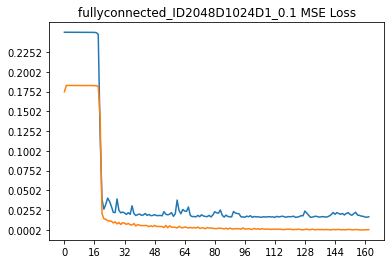

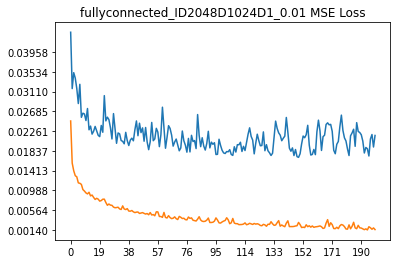

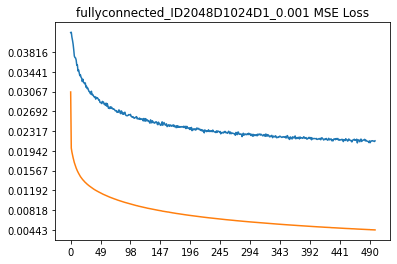

minY  0.0160226207226514
maxY  0.2501922845840454
layers [('Input', 21504), ('Dense', 1024), ('Dense', 512), ('Dense', 1)]
modelname  fullyconnected_ID1024D512D1_0.1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              22021120  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 22,546,433
Trainable params: 22,546,433
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID1024D512D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID1024D512D1_0.1.csv
Epoch 1/500
14/14 [====

14/14 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0253
Epoch 71/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0204
Epoch 72/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0209
Epoch 73/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0231
Epoch 74/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0270
Epoch 75/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0167
Epoch 76/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0169
Epoch 77/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0172
Epoch 78/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0191
Epoch 79/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0166
Epo

Epoch 1/500
14/14 [==============================] - 1s 50ms/step - loss: 0.0189 - val_loss: 0.0393
Epoch 2/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0155 - val_loss: 0.0313
Epoch 3/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0139 - val_loss: 0.0340
Epoch 4/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.0335
Epoch 5/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0126 - val_loss: 0.0302
Epoch 6/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0116 - val_loss: 0.0295
Epoch 7/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0112 - val_loss: 0.0302
Epoch 8/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 0.0276
Epoch 9/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0102 - val_loss: 0.0270
Epoch 10/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.0287

14/14 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.0200
Epoch 83/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.0191
Epoch 84/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0037 - val_loss: 0.0224
Epoch 85/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.0211
Epoch 86/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0036 - val_loss: 0.0206
Epoch 87/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.0209
Epoch 88/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0193
Epoch 89/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0199
Epoch 90/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0194
Epoch 91/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0200
Epo

14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0220
Epoch 163/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0223
Epoch 164/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0203
Epoch 165/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0179
Epoch 166/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0215
Epoch 167/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0233
Epoch 168/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0216
Epoch 169/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0215
Epoch 170/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0223
Epoch 171/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0178
Epoch 243/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0177
Epoch 244/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0166
Epoch 245/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0202
Epoch 246/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0184
Epoch 247/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0165
Epoch 248/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 249/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0205
Epoch 250/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0187
Epoch 251/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 8.0811e-04 - val_loss: 0.0196
Epoch 322/500
14/14 [==============================] - 0s 19ms/step - loss: 9.2393e-04 - val_loss: 0.0166
Epoch 323/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0188
Epoch 324/500
14/14 [==============================] - 0s 19ms/step - loss: 7.9346e-04 - val_loss: 0.0190
Epoch 325/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.0203
Epoch 326/500
14/14 [==============================] - 0s 19ms/step - loss: 7.9317e-04 - val_loss: 0.0184
Epoch 327/500
14/14 [==============================] - 0s 20ms/step - loss: 7.4047e-04 - val_loss: 0.0193
Epoch 00327: early stopping
Spearmans correlation coefficient: 0.773
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID1024D512D1_0.001
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output

Epoch 63/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0280
Epoch 64/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0281
Epoch 65/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 0.0280
Epoch 66/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0108 - val_loss: 0.0282
Epoch 67/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0107 - val_loss: 0.0281
Epoch 68/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0107 - val_loss: 0.0282
Epoch 69/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0107 - val_loss: 0.0279
Epoch 70/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0106 - val_loss: 0.0279
Epoch 71/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0277
Epoch 72/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0105 - val_los

14/14 [==============================] - 0s 20ms/step - loss: 0.0084 - val_loss: 0.0248
Epoch 144/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0084 - val_loss: 0.0246
Epoch 145/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0084 - val_loss: 0.0251
Epoch 146/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0084 - val_loss: 0.0249
Epoch 147/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0250
Epoch 148/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0246
Epoch 149/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0247
Epoch 150/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 151/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0.0251
Epoch 152/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0

14/14 [==============================] - 0s 26ms/step - loss: 0.0071 - val_loss: 0.0235
Epoch 224/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0071 - val_loss: 0.0232
Epoch 225/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 226/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 227/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0070 - val_loss: 0.0235
Epoch 228/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 229/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 230/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 231/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 0.0234
Epoch 232/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0070 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 304/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0225
Epoch 305/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0224
Epoch 306/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0227
Epoch 307/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0224
Epoch 308/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0225
Epoch 309/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0226
Epoch 310/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0061 - val_loss: 0.0226
Epoch 311/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0061 - val_loss: 0.0226
Epoch 312/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0061 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0220
Epoch 384/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 385/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0218
Epoch 386/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0217
Epoch 387/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0218
Epoch 388/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0218
Epoch 389/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0216
Epoch 390/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0218
Epoch 391/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 392/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0

14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0212
Epoch 464/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0215
Epoch 465/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0214
Epoch 466/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0215
Epoch 467/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0213
Epoch 468/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0215
Epoch 469/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0213
Epoch 470/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0215
Epoch 471/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0209
Epoch 472/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0

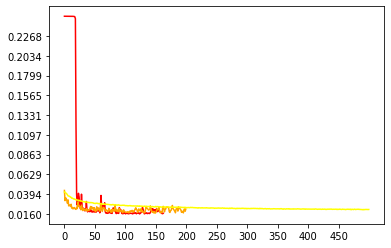

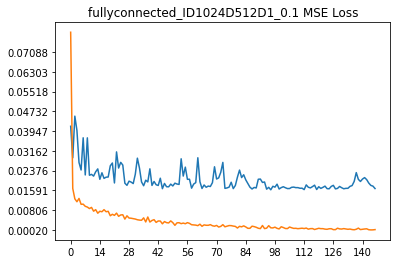

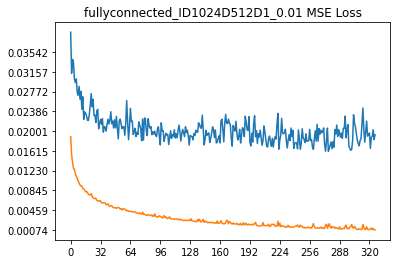

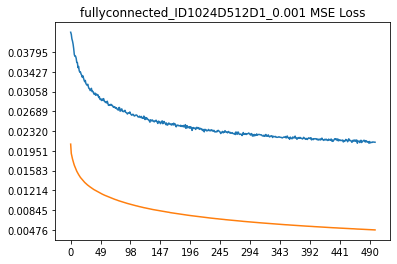

minY  0.0160499885678291
maxY  0.045400433242321
layers [('Input', 21504), ('Dense', 2048), ('Dense', 512), ('Dense', 1)]
modelname  fullyconnected_ID2048D512D1_0.1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2048)              44042240  
_________________________________________________________________
dense_19 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 45,091,841
Trainable params: 45,091,841
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID2048D512D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID2048D512D1_0.1.csv
Epoch 1/500
14/14 [=====

14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0163
Epoch 71/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0166
Epoch 72/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0175
Epoch 73/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0170
Epoch 74/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0172
Epoch 75/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0177
Epoch 76/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0221
Epoch 77/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0192
Epoch 78/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0162
Epoch 79/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0165
Epo

Epoch 37/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0057 - val_loss: 0.0198
Epoch 38/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 0.0219
Epoch 39/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0183
Epoch 40/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0204
Epoch 41/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0207
Epoch 42/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0201
Epoch 43/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - val_loss: 0.0211
Epoch 44/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0266
Epoch 45/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0175
Epoch 46/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0050 - val_los

Epoch 118/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0198
Epoch 119/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0170
Epoch 120/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0199
Epoch 121/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0167
Epoch 122/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0171
Epoch 123/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0203
Epoch 124/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0202
Epoch 125/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0185
Epoch 126/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0193
Epoch 127/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0028

14/14 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0197
Epoch 199/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0180
Epoch 200/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0203
Epoch 00200: early stopping
Spearmans correlation coefficient: 0.802
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID2048D512D1_0.001
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 2048)              44042240  
_________________________________________________________________
dense_25 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 45,091,841
Trainable params: 45,091,841
Non-trainable

14/14 [==============================] - 0s 27ms/step - loss: 0.0107 - val_loss: 0.0270
Epoch 68/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0107 - val_loss: 0.0269
Epoch 69/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0106 - val_loss: 0.0267
Epoch 70/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 71/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0105 - val_loss: 0.0265
Epoch 72/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0105 - val_loss: 0.0268
Epoch 73/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0104 - val_loss: 0.0266
Epoch 74/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0104 - val_loss: 0.0265
Epoch 75/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0261
Epoch 76/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0262
Epo

Epoch 148/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0080 - val_loss: 0.0232
Epoch 149/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0080 - val_loss: 0.0231
Epoch 150/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0232
Epoch 151/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0237
Epoch 152/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0229
Epoch 153/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0231
Epoch 154/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0234
Epoch 155/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0231
Epoch 156/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 157/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0078

14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0216
Epoch 229/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 230/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0216
Epoch 231/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0218
Epoch 232/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 233/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0216
Epoch 234/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 235/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0215
Epoch 236/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 237/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0064 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0208
Epoch 309/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0209
Epoch 310/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0209
Epoch 311/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 0.0209
Epoch 312/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0210
Epoch 313/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 0.0208
Epoch 314/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0056 - val_loss: 0.0209
Epoch 315/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0208
Epoch 316/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0206
Epoch 317/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0

14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0202
Epoch 389/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0200
Epoch 390/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0202
Epoch 391/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0203
Epoch 392/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - val_loss: 0.0202
Epoch 393/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0202
Epoch 394/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - val_loss: 0.0201
Epoch 395/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0203
Epoch 396/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0198
Epoch 397/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0

14/14 [==============================] - 0s 34ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 469/500
14/14 [==============================] - 0s 32ms/step - loss: 0.0044 - val_loss: 0.0197
Epoch 470/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 471/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0193
Epoch 472/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0198
Epoch 473/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 474/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0044 - val_loss: 0.0197
Epoch 475/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0196
Epoch 476/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 477/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0

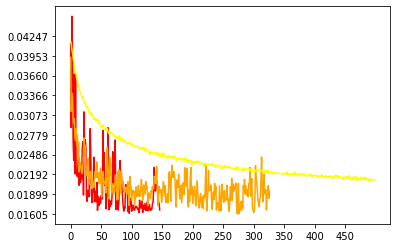

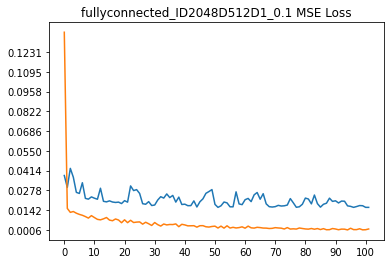

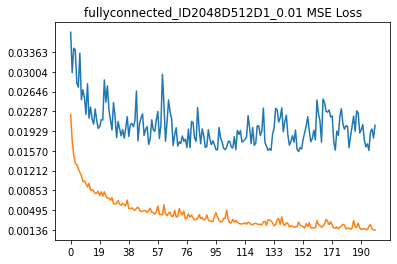

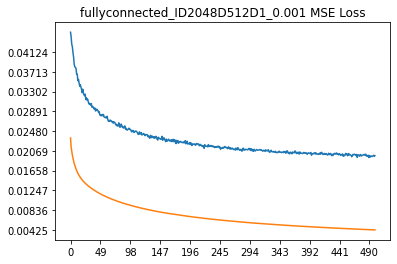

minY  0.0155728356912732
maxY  0.045351218432188
layers [('Input', 21504), ('Dense', 1024), ('Dense', 256), ('Dense', 1)]
modelname  fullyconnected_ID1024D256D1_0.1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              22021120  
_________________________________________________________________
dense_28 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 22,283,777
Trainable params: 22,283,777
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID1024D256D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID1024D256D1_0.1.csv
Epoch 1/500
14/14 [=====

14/14 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0234
Epoch 71/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0024 - val_loss: 0.0207
Epoch 72/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0225
Epoch 73/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0162
Epoch 74/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0177
Epoch 75/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0173
Epoch 76/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0236
Epoch 77/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0194
Epoch 78/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0186
Epoch 79/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0024 - val_loss: 0.0159
Epo

Epoch 1/500
14/14 [==============================] - 1s 39ms/step - loss: 0.0185 - val_loss: 0.0383
Epoch 2/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0159 - val_loss: 0.0314
Epoch 3/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0141 - val_loss: 0.0354
Epoch 4/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0331
Epoch 5/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0128 - val_loss: 0.0304
Epoch 6/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0117 - val_loss: 0.0288
Epoch 7/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0111 - val_loss: 0.0313
Epoch 8/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 0.0272
Epoch 9/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0104 - val_loss: 0.0279
Epoch 10/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0100 - val_loss: 0.0270

14/14 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0192
Epoch 83/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 0.0190
Epoch 84/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.0232
Epoch 85/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0038 - val_loss: 0.0218
Epoch 86/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0206
Epoch 87/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0209
Epoch 88/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0212
Epoch 89/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0190
Epoch 90/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.0193
Epoch 91/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 0.0224
Epo

14/14 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0.0223
Epoch 163/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0224
Epoch 164/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0228
Epoch 165/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0190
Epoch 166/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0239
Epoch 167/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0022 - val_loss: 0.0240
Epoch 168/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 0.0230
Epoch 169/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0220
Epoch 170/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0232
Epoch 171/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0

Epoch 31/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0313
Epoch 32/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0129 - val_loss: 0.0313
Epoch 33/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0128 - val_loss: 0.0311
Epoch 34/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.0310
Epoch 35/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0126 - val_loss: 0.0315
Epoch 36/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0126 - val_loss: 0.0307
Epoch 37/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0307
Epoch 38/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0124 - val_loss: 0.0306
Epoch 39/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0123 - val_loss: 0.0303
Epoch 40/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0122 - val_los

Epoch 112/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0090 - val_loss: 0.0258
Epoch 113/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0259
Epoch 114/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0261
Epoch 115/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0258
Epoch 116/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0258
Epoch 117/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0259
Epoch 118/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0256
Epoch 119/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0257
Epoch 120/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0256
Epoch 121/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0088

14/14 [==============================] - 0s 20ms/step - loss: 0.0073 - val_loss: 0.0243
Epoch 193/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0073 - val_loss: 0.0241
Epoch 194/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0073 - val_loss: 0.0239
Epoch 195/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0241
Epoch 196/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0238
Epoch 197/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0241
Epoch 198/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0072 - val_loss: 0.0238
Epoch 199/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0241
Epoch 200/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0071 - val_loss: 0.0235
Epoch 201/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0071 - val_loss: 0

14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0230
Epoch 273/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 274/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 275/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0232
Epoch 276/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0232
Epoch 277/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0227
Epoch 278/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 279/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0226
Epoch 280/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0061 - val_loss: 0.0227
Epoch 281/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0222
Epoch 353/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0224
Epoch 354/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0221
Epoch 355/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0222
Epoch 356/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0225
Epoch 357/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0223
Epoch 358/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0220
Epoch 359/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0221
Epoch 360/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0220
Epoch 361/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0217
Epoch 433/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0218
Epoch 434/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0219
Epoch 435/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0218
Epoch 436/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0220
Epoch 437/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0220
Epoch 438/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0218
Epoch 439/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0220
Epoch 440/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0217
Epoch 441/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0

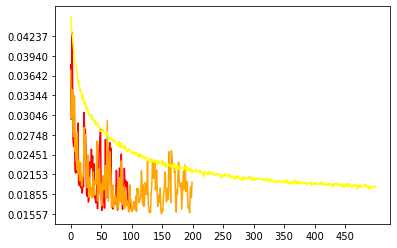

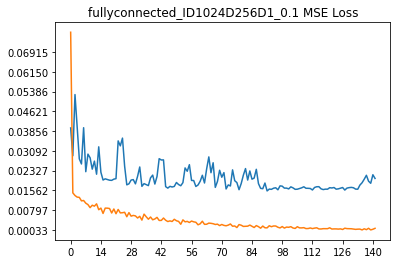

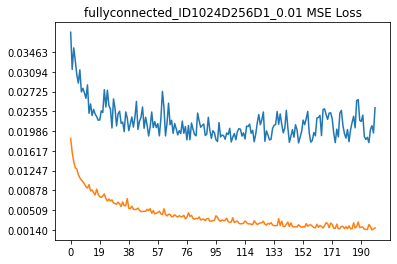

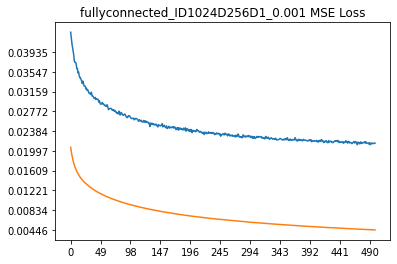

minY  0.0154084311798214
maxY  0.0526917353272438
layers [('Input', 21504), ('Dense', 1024), ('Dense', 12), ('Dense', 1)]
modelname  fullyconnected_ID1024D12D1_0.1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1024)              22021120  
_________________________________________________________________
dense_37 (Dense)             (None, 12)                12300     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 13        
Total params: 22,033,433
Trainable params: 22,033,433
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID1024D12D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID1024D12D1_0.1.csv
Epoch 1/500
14/14 [=======

14/14 [==============================] - 0s 19ms/step - loss: 0.0047 - val_loss: 0.0227
Epoch 71/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0052 - val_loss: 0.0193
Epoch 72/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0226
Epoch 73/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0045 - val_loss: 0.0178
Epoch 74/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 75/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0045 - val_loss: 0.0306
Epoch 76/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0217
Epoch 77/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0154
Epoch 78/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0055 - val_loss: 0.0165
Epoch 79/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0151
Epo

14/14 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0186
Epoch 151/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0175
Epoch 152/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0235
Epoch 153/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0029 - val_loss: 0.0210
Epoch 154/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0243
Epoch 155/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0029 - val_loss: 0.0181
Epoch 156/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0253
Epoch 157/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0029 - val_loss: 0.0190
Epoch 158/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0151
Epoch 159/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0

14/14 [==============================] - 0s 18ms/step - loss: 0.0162 - val_loss: 0.0349
Epoch 3/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0149 - val_loss: 0.0339
Epoch 4/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.0343
Epoch 5/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0135 - val_loss: 0.0323
Epoch 6/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0313
Epoch 7/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0301
Epoch 8/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0122 - val_loss: 0.0288
Epoch 9/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0119 - val_loss: 0.0295
Epoch 10/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0116 - val_loss: 0.0312
Epoch 11/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0113 - val_loss: 0.0285
Epoch 12/5

14/14 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0196
Epoch 84/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0216
Epoch 85/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0211
Epoch 86/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0205
Epoch 87/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0217
Epoch 88/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0201
Epoch 89/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0208
Epoch 90/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0202
Epoch 91/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0205
Epoch 92/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0047 - val_loss: 0.0202
Epo

14/14 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0193
Epoch 164/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0198
Epoch 165/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0181
Epoch 166/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0202
Epoch 167/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0195
Epoch 168/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0192
Epoch 169/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0030 - val_loss: 0.0196
Epoch 170/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 0.0201
Epoch 171/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 0.0192
Epoch 172/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0030 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0185
Epoch 244/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0182
Epoch 245/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0188
Epoch 246/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0183
Epoch 247/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0182
Epoch 248/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 249/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0187
Epoch 250/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0179
Epoch 251/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0179
Epoch 252/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0192
Epoch 324/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0174
Epoch 00324: early stopping
Spearmans correlation coefficient: 0.783
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID1024D12D1_0.001
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1024)              22021120  
_________________________________________________________________
dense_43 (Dense)             (None, 12)                12300     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 13        
Total params: 22,033,433
Trainable params: 22,033,433
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path 

14/14 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0292
Epoch 69/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0117 - val_loss: 0.0291
Epoch 70/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0291
Epoch 71/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0290
Epoch 72/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0116 - val_loss: 0.0289
Epoch 73/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0116 - val_loss: 0.0288
Epoch 74/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0116 - val_loss: 0.0289
Epoch 75/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0115 - val_loss: 0.0288
Epoch 76/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0115 - val_loss: 0.0287
Epoch 77/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0114 - val_loss: 0.0285
Epo

Epoch 149/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0095 - val_loss: 0.0259
Epoch 150/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0095 - val_loss: 0.0259
Epoch 151/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0095 - val_loss: 0.0262
Epoch 152/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0095 - val_loss: 0.0258
Epoch 153/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0094 - val_loss: 0.0259
Epoch 154/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0094 - val_loss: 0.0261
Epoch 155/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0094 - val_loss: 0.0260
Epoch 156/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0094 - val_loss: 0.0258
Epoch 157/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0094 - val_loss: 0.0255
Epoch 158/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0094

14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0240
Epoch 230/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 231/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 232/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0242
Epoch 233/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 234/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 235/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0240
Epoch 236/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0240
Epoch 237/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0081 - val_loss: 0.0239
Epoch 238/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0231
Epoch 310/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0230
Epoch 311/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0231
Epoch 312/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0229
Epoch 313/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0229
Epoch 314/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0072 - val_loss: 0.0229
Epoch 315/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0228
Epoch 316/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0228
Epoch 317/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0229
Epoch 318/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0220
Epoch 390/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 391/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0223
Epoch 392/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0222
Epoch 393/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0223
Epoch 394/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 395/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0222
Epoch 396/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0219
Epoch 397/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0220
Epoch 398/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0215
Epoch 470/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0.0215
Epoch 471/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0211
Epoch 472/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0214
Epoch 473/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0215
Epoch 474/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0214
Epoch 475/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0212
Epoch 476/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0215
Epoch 477/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0216
Epoch 478/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0

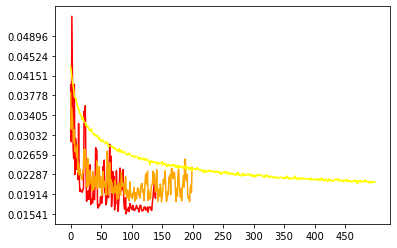

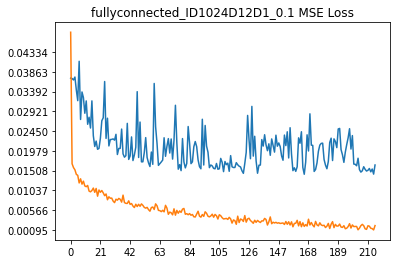

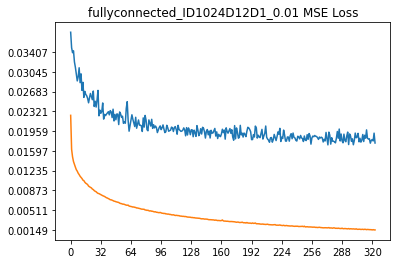

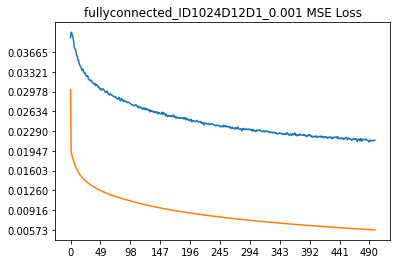

minY  0.0142078353092074
maxY  0.0411250703036785
layers [('Input', 21504), ('Dense', 512), ('Dense', 24), ('Dense', 1)]
modelname  fullyconnected_ID512D24D1_0.1
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               11010560  
_________________________________________________________________
dense_46 (Dense)             (None, 24)                12312     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 25        
Total params: 11,022,897
Trainable params: 11,022,897
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID512D24D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID512D24D1_0.1.csv
Epoch 1/500
14/14 [===========

14/14 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0.0204
Epoch 71/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0230
Epoch 72/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0041 - val_loss: 0.0162
Epoch 73/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0170
Epoch 74/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0182
Epoch 75/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0171
Epoch 76/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0163
Epoch 77/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 0.0184
Epoch 78/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0172
Epoch 79/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0159
Epo

14/14 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0161
Epoch 151/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0158
Epoch 152/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 153/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 154/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0166
Epoch 155/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0155
Epoch 156/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0185
Epoch 157/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0213
Epoch 158/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0208
Epoch 159/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0201
Epoch 57/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0216
Epoch 58/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0198
Epoch 59/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0200
Epoch 60/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0204
Epoch 61/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0285
Epoch 62/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0225
Epoch 63/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0184
Epoch 64/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0203
Epoch 65/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0217
Epo

Epoch 137/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0193
Epoch 138/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0195
Epoch 139/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0211
Epoch 140/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0191
Epoch 141/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0197
Epoch 142/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0222
Epoch 143/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0201
Epoch 144/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0179
Epoch 145/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 146/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0029

14/14 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0179
Epoch 218/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0171
Epoch 219/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0183
Epoch 220/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0172
Epoch 221/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0188
Epoch 222/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0215
Epoch 223/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0222
Epoch 224/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0163
Epoch 225/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0170
Epoch 226/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0190
Epoch 298/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0230
Epoch 299/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0184
Epoch 300/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0172
Epoch 301/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0159
Epoch 302/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0168
Epoch 303/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0169
Epoch 304/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0188
Epoch 305/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0192
Epoch 306/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0152 - val_loss: 0.0343
Epoch 15/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0339
Epoch 16/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0148 - val_loss: 0.0337
Epoch 17/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0336
Epoch 18/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0146 - val_loss: 0.0333
Epoch 19/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0144 - val_loss: 0.0330
Epoch 20/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0325
Epoch 21/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0142 - val_loss: 0.0329
Epoch 22/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0141 - val_loss: 0.0325
Epoch 23/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0140 - val_loss: 0.0323
Epo

14/14 [==============================] - 0s 16ms/step - loss: 0.0101 - val_loss: 0.0263
Epoch 96/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0264
Epoch 97/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0264
Epoch 98/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0263
Epoch 99/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0263
Epoch 100/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0262
Epoch 101/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0260
Epoch 102/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0259
Epoch 103/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0261
Epoch 104/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0098 - val_loss: 0.026

14/14 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 176/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0240
Epoch 177/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0242
Epoch 178/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0239
Epoch 179/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0240
Epoch 180/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0239
Epoch 181/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 182/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0239
Epoch 183/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 184/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0228
Epoch 256/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0228
Epoch 257/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0228
Epoch 258/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0225
Epoch 259/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0227
Epoch 260/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0228
Epoch 261/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0227
Epoch 262/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0227
Epoch 263/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0225
Epoch 264/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0218
Epoch 336/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0218
Epoch 337/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0219
Epoch 338/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0218
Epoch 339/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0217
Epoch 340/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0218
Epoch 341/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0217
Epoch 342/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0217
Epoch 343/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0219
Epoch 344/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0213
Epoch 416/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 417/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0213
Epoch 418/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 419/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 420/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0214
Epoch 421/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 422/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 423/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 424/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0206
Epoch 496/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0208
Epoch 497/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0207
Epoch 498/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0207
Epoch 499/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0206
Epoch 500/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0208
Spearmans correlation coefficient: 0.742
Samples are correlated (reject H0) p=0.000


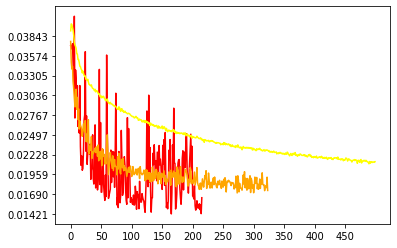

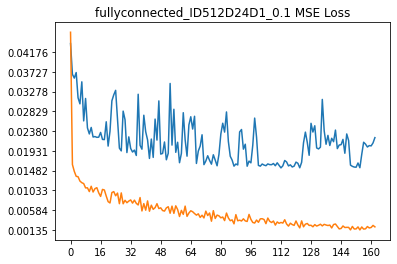

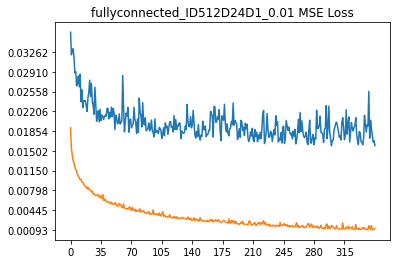

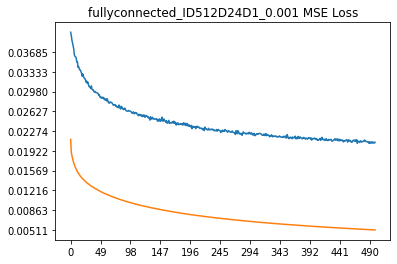

minY  0.0154425902292132
maxY  0.0436765477061271
layers [('Input', 21504), ('Dense', 256), ('Dense', 48), ('Dense', 1)]
modelname  fullyconnected_ID256D48D1_0.1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 256)               5505280   
_________________________________________________________________
dense_55 (Dense)             (None, 48)                12336     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 49        
Total params: 5,517,665
Trainable params: 5,517,665
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID256D48D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID256D48D1_0.1.csv
Epoch 1/500
14/14 [=============

14/14 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0204
Epoch 71/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0211
Epoch 72/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0239
Epoch 73/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0192
Epoch 74/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0270
Epoch 75/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0168
Epoch 76/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0159
Epoch 77/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0177
Epoch 78/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0174
Epoch 79/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0163
Epo

14/14 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0165
Epoch 151/500
14/14 [==============================] - 0s 16ms/step - loss: 9.3515e-04 - val_loss: 0.0160
Epoch 152/500
14/14 [==============================] - 0s 14ms/step - loss: 9.4558e-04 - val_loss: 0.0162
Epoch 153/500
14/14 [==============================] - 0s 15ms/step - loss: 7.8098e-04 - val_loss: 0.0171
Epoch 154/500
14/14 [==============================] - 0s 15ms/step - loss: 8.7336e-04 - val_loss: 0.0167
Epoch 155/500
14/14 [==============================] - 0s 15ms/step - loss: 7.7043e-04 - val_loss: 0.0158
Epoch 156/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0173
Epoch 157/500
14/14 [==============================] - 0s 15ms/step - loss: 5.8384e-04 - val_loss: 0.0166
Epoch 158/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0161
Epoch 159/500
14/14 [==============================] - 0s 15ms/step - lo

14/14 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0233
Epoch 51/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0210
Epoch 52/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0188
Epoch 53/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0224
Epoch 54/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0238
Epoch 55/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0203
Epoch 56/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0212
Epoch 57/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0203
Epoch 58/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0198
Epoch 59/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0189
Epo

Epoch 131/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0031 - val_loss: 0.0181
Epoch 132/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0190
Epoch 133/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0192
Epoch 134/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0189
Epoch 135/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0220
Epoch 136/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0220
Epoch 137/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0187
Epoch 138/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0031 - val_loss: 0.0214
Epoch 139/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0034 - val_loss: 0.0200
Epoch 140/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0030

14/14 [==============================] - 0s 14ms/step - loss: 0.0137 - val_loss: 0.0320
Epoch 22/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0136 - val_loss: 0.0315
Epoch 23/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0135 - val_loss: 0.0312
Epoch 24/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0133 - val_loss: 0.0311
Epoch 25/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0312
Epoch 26/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0307
Epoch 27/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0309
Epoch 28/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0130 - val_loss: 0.0305
Epoch 29/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0129 - val_loss: 0.0308
Epoch 30/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 0.0303
Epo

14/14 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0260
Epoch 103/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0260
Epoch 104/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0260
Epoch 105/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0258
Epoch 106/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0098 - val_loss: 0.0258
Epoch 107/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0098 - val_loss: 0.0259
Epoch 108/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0261
Epoch 109/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0098 - val_loss: 0.0260
Epoch 110/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0097 - val_loss: 0.0258
Epoch 111/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0097 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0085 - val_loss: 0.0243
Epoch 183/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0243
Epoch 184/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0241
Epoch 185/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0242
Epoch 186/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0243
Epoch 187/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0240
Epoch 188/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0244
Epoch 189/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0244
Epoch 190/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0.0240
Epoch 191/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0230
Epoch 263/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0231
Epoch 264/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0230
Epoch 265/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 0.0230
Epoch 266/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0231
Epoch 267/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0229
Epoch 268/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0228
Epoch 269/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0229
Epoch 270/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0228
Epoch 271/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0222
Epoch 343/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0224
Epoch 344/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0223
Epoch 345/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0223
Epoch 346/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0223
Epoch 347/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0220
Epoch 348/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0221
Epoch 349/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0222
Epoch 350/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0223
Epoch 351/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0216
Epoch 423/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0217
Epoch 424/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0219
Epoch 425/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0217
Epoch 426/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0217
Epoch 427/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0217
Epoch 428/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0218
Epoch 429/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0215
Epoch 430/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0.0218
Epoch 431/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0061 - val_loss: 0

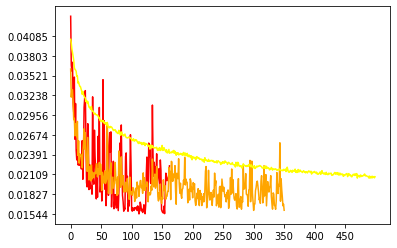

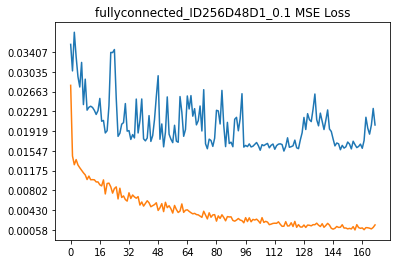

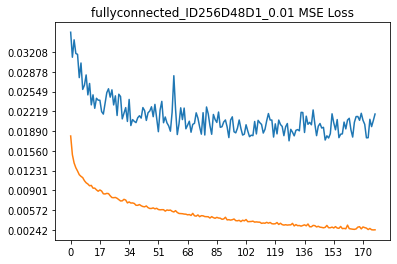

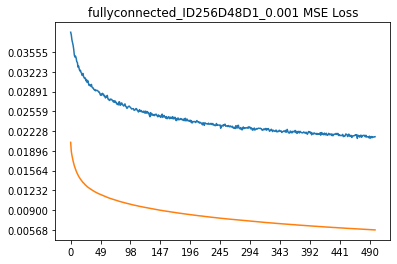

minY  0.0154255013912916
maxY  0.0388699248433113
layers [('Input', 21504), ('Dense', 128), ('Dense', 96), ('Dense', 1)]
modelname  fullyconnected_ID128D96D1_0.1
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               2752640   
_________________________________________________________________
dense_64 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 97        
Total params: 2,765,121
Trainable params: 2,765,121
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID128D96D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID128D96D1_0.1.csv
Epoch 1/500
14/14 [=============

14/14 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.0186
Epoch 71/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0045 - val_loss: 0.0164
Epoch 72/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0172
Epoch 73/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0162
Epoch 74/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 0.0167
Epoch 75/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0165
Epoch 76/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0217
Epoch 77/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0174
Epoch 78/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0170
Epoch 79/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.0156
Epo

14/14 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0178
Epoch 151/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0176
Epoch 152/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0177
Epoch 153/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0200
Epoch 154/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0187
Epoch 155/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0182
Epoch 156/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0242
Epoch 157/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0.0191
Epoch 158/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0151
Epoch 159/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0

14/14 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0191
Epoch 57/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0061 - val_loss: 0.0188
Epoch 58/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 59/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 60/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0209
Epoch 61/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0057 - val_loss: 0.0263
Epoch 62/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0213
Epoch 63/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 0.0177
Epoch 64/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.0195
Epoch 65/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0054 - val_loss: 0.0212
Epo

Epoch 137/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 0.0179
Epoch 138/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0190
Epoch 139/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0191
Epoch 140/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0190
Epoch 141/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0191
Epoch 142/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0220
Epoch 143/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0184
Epoch 144/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0197
Epoch 145/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0174
Epoch 146/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0031

14/14 [==============================] - 0s 15ms/step - loss: 0.0140 - val_loss: 0.0320
Epoch 28/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0139 - val_loss: 0.0317
Epoch 29/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0317
Epoch 30/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0315
Epoch 31/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0313
Epoch 32/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0136 - val_loss: 0.0312
Epoch 33/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0135 - val_loss: 0.0310
Epoch 34/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0135 - val_loss: 0.0310
Epoch 35/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0134 - val_loss: 0.0310
Epoch 36/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0134 - val_loss: 0.0307
Epo

14/14 [==============================] - 0s 14ms/step - loss: 0.0108 - val_loss: 0.0264
Epoch 109/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.0264
Epoch 110/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0108 - val_loss: 0.0262
Epoch 111/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0108 - val_loss: 0.0261
Epoch 112/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0260
Epoch 113/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0260
Epoch 114/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0261
Epoch 115/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0260
Epoch 116/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0106 - val_loss: 0.0260
Epoch 117/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0106 - val_loss: 0

14/14 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0242
Epoch 189/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0243
Epoch 190/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0093 - val_loss: 0.0240
Epoch 191/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0241
Epoch 192/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0242
Epoch 193/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0240
Epoch 194/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0239
Epoch 195/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0240
Epoch 196/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.0239
Epoch 197/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0

14/14 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0225
Epoch 269/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0226
Epoch 270/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0226
Epoch 271/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0224
Epoch 272/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0227
Epoch 273/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0225
Epoch 274/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0225
Epoch 275/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0228
Epoch 276/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0227
Epoch 277/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0

14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0215
Epoch 349/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0216
Epoch 350/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0216
Epoch 351/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0215
Epoch 352/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0214
Epoch 353/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0217
Epoch 354/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0215
Epoch 355/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0215
Epoch 356/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0218
Epoch 357/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0

14/14 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0211
Epoch 429/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0207
Epoch 430/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0208
Epoch 431/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0066 - val_loss: 0.0207
Epoch 432/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0066 - val_loss: 0.0208
Epoch 433/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0209
Epoch 434/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0210
Epoch 435/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0210
Epoch 436/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0211
Epoch 437/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0

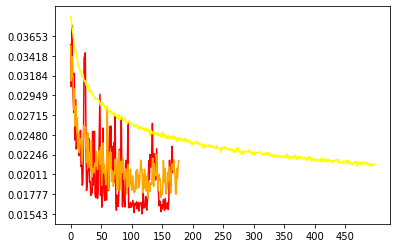

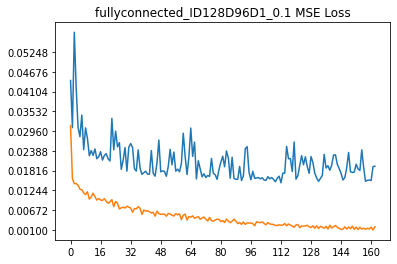

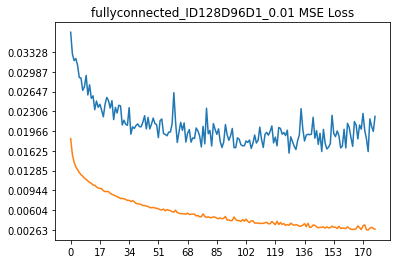

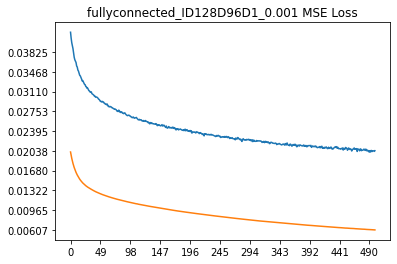

minY  0.0146454451605677
maxY  0.0582030266523361
layers [('Input', 21504), ('Dense', 512), ('Dense', 128), ('Dense', 1)]
modelname  fullyconnected_ID512D128D1_0.1
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 512)               11010560  
_________________________________________________________________
dense_73 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 129       
Total params: 11,076,353
Trainable params: 11,076,353
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/stack12step4/fullyconnected_ID512D128D1_0.1.hdf5
Path to log:   modelcheckpoints/stack12step4/fullyconnected_ID512D128D1_0.1.csv
Epoch 1/500
14/14 [=======

14/14 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0168
Epoch 71/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0164
Epoch 72/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0176
Epoch 73/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0175
Epoch 74/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0188
Epoch 75/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0177
Epoch 76/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0187
Epoch 77/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0192
Epoch 78/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0169
Epoch 79/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0160
Epo

14/14 [==============================] - 0s 15ms/step - loss: 5.2122e-04 - val_loss: 0.0201
Epoch 150/500
14/14 [==============================] - 0s 15ms/step - loss: 3.6676e-04 - val_loss: 0.0179
Epoch 151/500
14/14 [==============================] - 0s 15ms/step - loss: 3.8548e-04 - val_loss: 0.0192
Epoch 152/500
14/14 [==============================] - 0s 15ms/step - loss: 6.6794e-04 - val_loss: 0.0203
Epoch 153/500
14/14 [==============================] - 0s 15ms/step - loss: 6.5451e-04 - val_loss: 0.0196
Epoch 154/500
14/14 [==============================] - 0s 15ms/step - loss: 3.4279e-04 - val_loss: 0.0178e-
Epoch 155/500
14/14 [==============================] - 0s 15ms/step - loss: 2.9856e-04 - val_loss: 0.0197
Epoch 00155: early stopping
Spearmans correlation coefficient: 0.812
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID512D128D1_0.01
Model: "sequential_25"
_________________________________________________________________
Layer (type)              

Epoch 63/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0183
Epoch 64/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0045 - val_loss: 0.0198
Epoch 65/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0045 - val_loss: 0.0234
Epoch 66/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0211
Epoch 67/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0045 - val_loss: 0.0226
Epoch 68/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0191
Epoch 69/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0202
Epoch 70/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0216
Epoch 71/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0185
Epoch 72/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0046 - val_los

14/14 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0183
Epoch 144/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0175
Epoch 145/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0185
Epoch 146/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0211
Epoch 147/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0174
Epoch 148/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0184
Epoch 149/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0184
Epoch 150/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0177
Epoch 151/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0175
Epoch 152/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0

Epoch 1/500
14/14 [==============================] - 1s 43ms/step - loss: 0.0182 - val_loss: 0.0382
Epoch 2/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0167 - val_loss: 0.0381
Epoch 3/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0163 - val_loss: 0.0376
Epoch 4/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0160 - val_loss: 0.0372
Epoch 5/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0368
Epoch 6/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0361
Epoch 7/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0152 - val_loss: 0.0354
Epoch 8/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0351
Epoch 9/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0148 - val_loss: 0.0352
Epoch 10/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0146 - val_loss: 0.0350

14/14 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0272
Epoch 83/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0273
Epoch 84/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0277
Epoch 85/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0276
Epoch 86/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0272
Epoch 87/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0101 - val_loss: 0.0273
Epoch 88/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0272
Epoch 89/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0274
Epoch 90/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0275
Epoch 91/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0100 - val_loss: 0.0272
Epo

14/14 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0251
Epoch 163/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0247
Epoch 164/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0248
Epoch 165/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0248
Epoch 166/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0247
Epoch 167/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0248
Epoch 168/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0250
Epoch 169/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0247
Epoch 170/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0250
Epoch 171/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0234
Epoch 243/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0234
Epoch 244/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0234
Epoch 245/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0232
Epoch 246/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0233
Epoch 247/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 248/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0231
Epoch 249/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 250/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 251/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0224
Epoch 323/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0226
Epoch 324/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0225
Epoch 325/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0226
Epoch 326/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 327/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 328/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0222
Epoch 329/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0224
Epoch 330/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0224
Epoch 331/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0218
Epoch 403/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0218
Epoch 404/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0217
Epoch 405/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0216
Epoch 406/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0217
Epoch 407/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0217
Epoch 408/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0056 - val_loss: 0.0217
Epoch 409/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0216
Epoch 410/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 411/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0

14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 483/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0214
Epoch 484/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0212
Epoch 485/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0215
Epoch 486/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0214
Epoch 487/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0212
Epoch 488/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0212
Epoch 489/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0212
Epoch 490/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0210
Epoch 491/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0

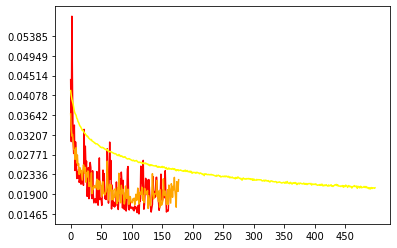

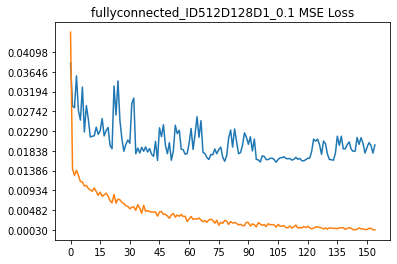

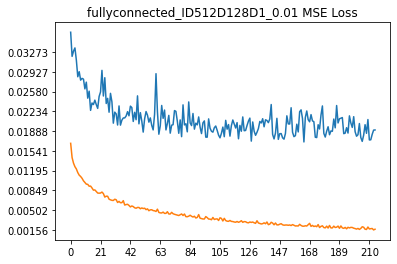

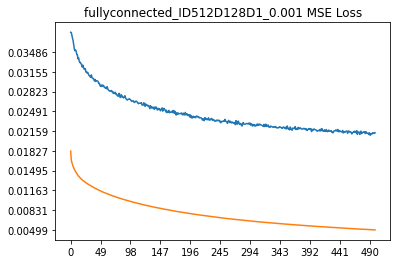

minY  0.0157783050090074
maxY  0.0384930409491062
layers [('Input', 21504), ('Dense', 2048), ('Dense', 1024), ('Dense', 512), ('Dense', 1)]
modelname  fullyconnected_ID2048D1024D512D1_0.1
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 2048)              44042240  
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_83 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 513       
Total params: 46,665,729
Trainable params: 46,665,729
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints

14/14 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0172
Epoch 69/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0181
Epoch 70/500
14/14 [==============================] - 0s 28ms/step - loss: 9.0272e-04 - val_loss: 0.0194
Epoch 71/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0218
Epoch 72/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0171
Epoch 73/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0180
Epoch 74/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0176
Epoch 75/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0178
Epoch 76/500
14/14 [==============================] - 0s 28ms/step - loss: 8.3825e-04 - val_loss: 0.0171
Epoch 77/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.

Epoch 26/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0074 - val_loss: 0.0219
Epoch 27/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0073 - val_loss: 0.0235
Epoch 28/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0.0222
Epoch 29/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0234
Epoch 30/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0241
Epoch 31/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0068 - val_loss: 0.0205
Epoch 32/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0067 - val_loss: 0.0213
Epoch 33/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0207
Epoch 34/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0065 - val_loss: 0.0211
Epoch 35/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0064 - val_los

14/14 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0177
Epoch 108/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0184
Epoch 109/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0185
Epoch 110/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0185
Epoch 111/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0184
Epoch 112/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0198
Epoch 113/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0182
Epoch 114/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0191
Epoch 115/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0198
Epoch 116/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 188/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 189/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0201
Epoch 190/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0188
Epoch 191/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0189
Epoch 192/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0195
Epoch 193/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0176
Epoch 194/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0167
Epoch 195/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0183
Epoch 196/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 9.9724e-04 - val_loss: 0.0192
Epoch 268/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0189
Epoch 269/500
14/14 [==============================] - 0s 28ms/step - loss: 9.4421e-04 - val_loss: 0.0181
Epoch 270/500
14/14 [==============================] - 0s 28ms/step - loss: 9.1242e-04 - val_loss: 0.0168
Epoch 271/500
14/14 [==============================] - 0s 28ms/step - loss: 9.1899e-04 - val_loss: 0.0185
Epoch 272/500
14/14 [==============================] - 0s 28ms/step - loss: 8.7135e-04 - val_loss: 0.0196
Epoch 273/500
14/14 [==============================] - 0s 28ms/step - loss: 9.0145e-04 - val_loss: 0.0178
Epoch 274/500
14/14 [==============================] - 0s 28ms/step - loss: 9.1651e-04 - val_loss: 0.0158
Epoch 275/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0176
Epoch 276/500
14/14 [==============================] - 0s 28ms/step 

14/14 [==============================] - 0s 28ms/step - loss: 9.4500e-04 - val_loss: 0.0193
Epoch 346/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0220
Epoch 347/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0200
Epoch 348/500
14/14 [==============================] - 0s 28ms/step - loss: 6.6050e-04 - val_loss: 0.0177
Epoch 349/500
14/14 [==============================] - 0s 28ms/step - loss: 5.4354e-04 - val_loss: 0.0169
Epoch 350/500
14/14 [==============================] - 0s 28ms/step - loss: 5.6161e-04 - val_loss: 0.0170
Epoch 351/500
14/14 [==============================] - 0s 28ms/step - loss: 7.4146e-04 - val_loss: 0.0160
Epoch 352/500
14/14 [==============================] - 0s 28ms/step - loss: 9.0160e-04 - val_loss: 0.0158
Epoch 353/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0153
Epoch 354/500
14/14 [==============================] - 0s 28ms/step - lo

14/14 [==============================] - 0s 28ms/step - loss: 0.0168 - val_loss: 0.0372
Epoch 8/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0165 - val_loss: 0.0369
Epoch 9/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0163 - val_loss: 0.0367
Epoch 10/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0161 - val_loss: 0.0365
Epoch 11/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0159 - val_loss: 0.0360
Epoch 12/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0157 - val_loss: 0.0358
Epoch 13/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0156 - val_loss: 0.0353
Epoch 14/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0154 - val_loss: 0.0352
Epoch 15/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0153 - val_loss: 0.0348
Epoch 16/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0151 - val_loss: 0.0345
Epoch

14/14 [==============================] - 0s 28ms/step - loss: 0.0106 - val_loss: 0.0270
Epoch 89/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0106 - val_loss: 0.0271
Epoch 90/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0106 - val_loss: 0.0271
Epoch 91/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0105 - val_loss: 0.0269
Epoch 92/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0105 - val_loss: 0.0269
Epoch 93/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0105 - val_loss: 0.0268
Epoch 94/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0266
Epoch 95/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0267
Epoch 96/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0267
Epoch 97/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0103 - val_loss: 0.0268
Epo

14/14 [==============================] - 0s 28ms/step - loss: 0.0086 - val_loss: 0.0245
Epoch 169/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0086 - val_loss: 0.0243
Epoch 170/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0086 - val_loss: 0.0244
Epoch 171/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0086 - val_loss: 0.0242
Epoch 172/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0243
Epoch 173/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0241
Epoch 174/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0240
Epoch 175/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0242
Epoch 176/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0241
Epoch 177/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0226
Epoch 249/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0226
Epoch 250/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0227
Epoch 251/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0226
Epoch 252/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0227
Epoch 253/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0227
Epoch 254/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0228
Epoch 255/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0.0226
Epoch 256/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0.0227
Epoch 257/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 329/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 330/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 331/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 332/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 333/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 334/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 335/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 336/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0216
Epoch 337/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0063 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0210
Epoch 409/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0209
Epoch 410/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 411/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0209
Epoch 412/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 413/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 414/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0209
Epoch 415/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0209
Epoch 416/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0208
Epoch 417/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0204
Epoch 489/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 0.0204
Epoch 490/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0202
Epoch 491/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0205
Epoch 492/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0051 - val_loss: 0.0202
Epoch 493/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0051 - val_loss: 0.0204
Epoch 494/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0051 - val_loss: 0.0205
Epoch 495/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0051 - val_loss: 0.0203
Epoch 496/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0051 - val_loss: 0.0204
Epoch 497/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0051 - val_loss: 0

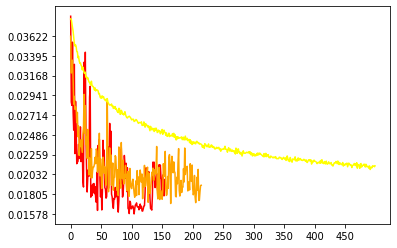

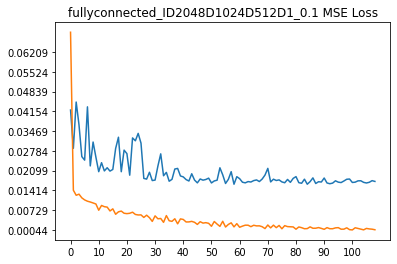

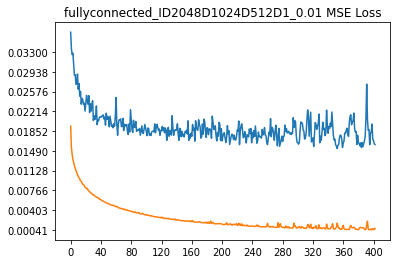

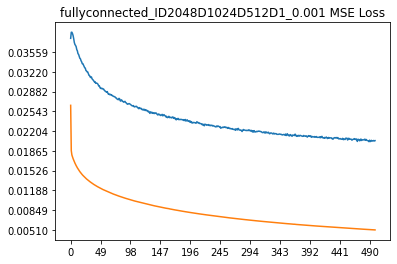

minY  0.0153146917000412
maxY  0.0447525046765804
layers [('Input', 21504), ('Dense', 2048), ('Dense', 1024), ('Dense', 256), ('Dense', 1)]
modelname  fullyconnected_ID2048D1024D256D1_0.1
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 2048)              44042240  
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_95 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 257       
Total params: 46,403,073
Trainable params: 46,403,073
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints

14/14 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0197
Epoch 69/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0282
Epoch 70/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0211
Epoch 71/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0214
Epoch 72/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0221
Epoch 73/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0255
Epoch 74/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0296
Epoch 75/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0170
Epoch 76/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0161
Epoch 77/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0161
Epo

Epoch 1/500
14/14 [==============================] - 1s 62ms/step - loss: 0.0168 - val_loss: 0.0364
Epoch 2/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0144 - val_loss: 0.0310
Epoch 3/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0132 - val_loss: 0.0317
Epoch 4/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0122 - val_loss: 0.0311
Epoch 5/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0117 - val_loss: 0.0300
Epoch 6/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0110 - val_loss: 0.0270
Epoch 7/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0106 - val_loss: 0.0279
Epoch 8/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0102 - val_loss: 0.0251
Epoch 9/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0097 - val_loss: 0.0269
Epoch 10/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0095 - val_loss: 0.0268

14/14 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0183
Epoch 83/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0033 - val_loss: 0.0169
Epoch 84/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0033 - val_loss: 0.0202
Epoch 85/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0184
Epoch 86/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0189
Epoch 87/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0200
Epoch 88/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0030 - val_loss: 0.0182
Epoch 89/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0178
Epoch 90/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0185
Epoch 91/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0197
Epo

14/14 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0214
Epoch 163/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0225
Epoch 164/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0208
Epoch 165/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0168
Epoch 166/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0198
Epoch 167/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0226
Epoch 168/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0235
Epoch 169/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0205
Epoch 170/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0197
Epoch 171/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0

14/14 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0156
Epoch 243/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0162
Epoch 244/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0159
Epoch 245/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0169
Epoch 246/500
14/14 [==============================] - 0s 28ms/step - loss: 9.8829e-04 - val_loss: 0.0163
Epoch 247/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 248/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0158
Epoch 249/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0182
Epoch 250/500
14/14 [==============================] - 0s 28ms/step - loss: 8.7605e-04 - val_loss: 0.0180
Epoch 251/500
14/14 [==============================] - 0s 29ms/step - loss: 8.5261e-04 -

Epoch 321/500
14/14 [==============================] - 0s 28ms/step - loss: 7.0215e-04 - val_loss: 0.0193
Epoch 322/500
14/14 [==============================] - 0s 28ms/step - loss: 6.4263e-04 - val_loss: 0.0163
Epoch 323/500
14/14 [==============================] - 0s 27ms/step - loss: 6.4357e-04 - val_loss: 0.0185
Epoch 324/500
14/14 [==============================] - 0s 28ms/step - loss: 6.6015e-04 - val_loss: 0.0192
Epoch 00324: early stopping
Spearmans correlation coefficient: 0.793
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID2048D1024D256D1_0.001
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 2048)              44042240  
_________________________________________________________________
dense_102 (Dense)            (None, 1024)              2098176   
_____________________________________________________________

14/14 [==============================] - 0s 28ms/step - loss: 0.0104 - val_loss: 0.0269
Epoch 65/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0103 - val_loss: 0.0267
Epoch 66/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0268
Epoch 67/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0103 - val_loss: 0.0267
Epoch 68/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 0.0268
Epoch 69/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 0.0265
Epoch 70/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0101 - val_loss: 0.0266
Epoch 71/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0101 - val_loss: 0.0265
Epoch 72/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0101 - val_loss: 0.0265
Epoch 73/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0263
Epo

Epoch 145/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0080 - val_loss: 0.0238
Epoch 146/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0080 - val_loss: 0.0237
Epoch 147/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0.0237
Epoch 148/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0.0235
Epoch 149/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0.0235
Epoch 150/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0.0237
Epoch 151/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0078 - val_loss: 0.0239
Epoch 152/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0078 - val_loss: 0.0234
Epoch 153/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0078 - val_loss: 0.0235
Epoch 154/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0078

14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0221
Epoch 226/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0221
Epoch 227/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0223
Epoch 228/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0220
Epoch 229/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0221
Epoch 230/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0066 - val_loss: 0.0221
Epoch 231/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 232/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 233/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 234/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 306/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0212
Epoch 307/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0211
Epoch 308/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0212
Epoch 309/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 310/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 311/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 312/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0213
Epoch 313/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0212
Epoch 314/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0205
Epoch 386/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0204
Epoch 387/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0207
Epoch 388/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0204
Epoch 389/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0205
Epoch 390/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0205
Epoch 391/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0207
Epoch 392/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0206
Epoch 393/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0.0206
Epoch 394/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0201
Epoch 466/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0202
Epoch 467/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0201
Epoch 468/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0200
Epoch 469/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0199
Epoch 470/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0202
Epoch 471/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0196
Epoch 472/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0200
Epoch 473/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0201
Epoch 474/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0

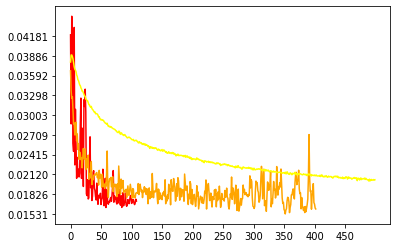

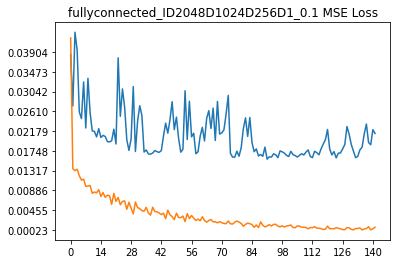

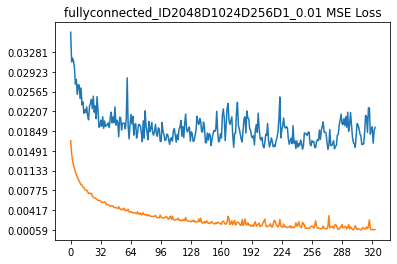

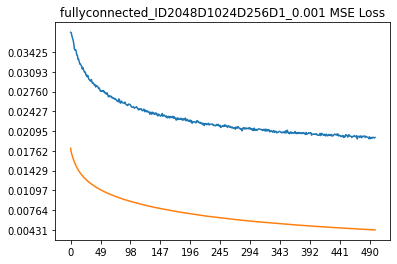

minY  0.0152037683874368
maxY  0.0433498620986938
layers [('Input', 21504), ('Dense', 1024), ('Dense', 512), ('Dense', 256), ('Dense', 1)]
modelname  fullyconnected_ID1024D512D256D1_0.1
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 1024)              22021120  
_________________________________________________________________
dense_106 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_107 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 257       
Total params: 22,677,505
Trainable params: 22,677,505
Non-trainable params: 0
_________________________________________________________________
Callbacks created:

Path to model: modelcheckpoints/s

14/14 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0165
Epoch 69/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0185
Epoch 70/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0260
Epoch 71/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0200
Epoch 72/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0217
Epoch 73/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0182
Epoch 74/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0169
Epoch 75/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0029 - val_loss: 0.0181
Epoch 76/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0230
Epoch 77/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0176
Epo

Epoch 147/500
14/14 [==============================] - 0s 20ms/step - loss: 4.6000e-04 - val_loss: 0.0170
Epoch 00147: early stopping
Spearmans correlation coefficient: 0.797
Samples are correlated (reject H0) p=0.000
modelname  fullyconnected_ID1024D512D256D1_0.01
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 1024)              22021120  
_________________________________________________________________
dense_110 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_111 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 257       
Total params: 22,677,505
Trainable params: 22,677,505
Non-trainable params: 0
_______________________________________

14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0225
Epoch 68/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0202
Epoch 69/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0210
Epoch 70/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0220
Epoch 71/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0197
Epoch 72/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0208
Epoch 73/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0213
Epoch 74/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0204
Epoch 75/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0203
Epoch 76/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0045 - val_loss: 0.0204
Epo

Epoch 148/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0188
Epoch 149/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0182
Epoch 150/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0192
Epoch 151/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0184
Epoch 152/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0190
Epoch 153/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0191
Epoch 154/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0206
Epoch 155/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0190
Epoch 156/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0201
Epoch 157/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0024

14/14 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0199
Epoch 229/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0178
Epoch 230/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0183
Epoch 231/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0200
Epoch 232/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0177
Epoch 233/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.0174
Epoch 234/500
14/14 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0187
Epoch 235/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0195
Epoch 236/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0184
Epoch 237/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0

14/14 [==============================] - 0s 20ms/step - loss: 9.5422e-04 - val_loss: 0.0194
Epoch 309/500
14/14 [==============================] - 0s 20ms/step - loss: 9.6947e-04 - val_loss: 0.0190
Epoch 310/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0176
Epoch 311/500
14/14 [==============================] - 0s 21ms/step - loss: 9.1506e-04 - val_loss: 0.0194
Epoch 312/500
14/14 [==============================] - 0s 20ms/step - loss: 8.9751e-04 - val_loss: 0.0187
Epoch 313/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0212
Epoch 314/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0214
Epoch 315/500
14/14 [==============================] - 0s 21ms/step - loss: 9.9376e-04 - val_loss: 0.0191
Epoch 316/500
14/14 [==============================] - 0s 20ms/step - loss: 9.6409e-04 - val_loss: 0.0178
Epoch 317/500
14/14 [==============================] - 0s 20ms/step - lo

Epoch 48/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0120 - val_loss: 0.0302
Epoch 49/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0120 - val_loss: 0.0300
Epoch 50/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0119 - val_loss: 0.0299
Epoch 51/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0119 - val_loss: 0.0299
Epoch 52/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0119 - val_loss: 0.0298
Epoch 53/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0299
Epoch 54/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0298
Epoch 55/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0117 - val_loss: 0.0298
Epoch 56/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0117 - val_loss: 0.0297
Epoch 57/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0117 - val_los

Epoch 129/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0097 - val_loss: 0.0267
Epoch 130/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0097 - val_loss: 0.0265
Epoch 131/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0264
Epoch 132/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0096 - val_loss: 0.0266
Epoch 133/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0266
Epoch 134/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0264
Epoch 135/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0265
Epoch 136/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0095 - val_loss: 0.0264
Epoch 137/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0095 - val_loss: 0.0265
Epoch 138/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0095

14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 210/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 211/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0249
Epoch 212/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0248
Epoch 213/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0248
Epoch 214/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0249
Epoch 215/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0248
Epoch 216/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0249
Epoch 217/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0.0246
Epoch 218/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0

14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 290/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0238
Epoch 291/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 292/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 293/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0238
Epoch 294/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 295/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 296/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0236
Epoch 297/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 298/500
14/14 [==============================] - 0s 23ms/step - loss: 0.0072 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0230
Epoch 370/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0228
Epoch 371/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0228
Epoch 372/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0226
Epoch 373/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0226
Epoch 374/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0228
Epoch 375/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0227
Epoch 376/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0227
Epoch 377/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0228
Epoch 378/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0221
Epoch 450/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0220
Epoch 451/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0221
Epoch 452/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 453/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0222
Epoch 454/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0222
Epoch 455/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0220
Epoch 456/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0221
Epoch 457/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0222
Epoch 458/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0

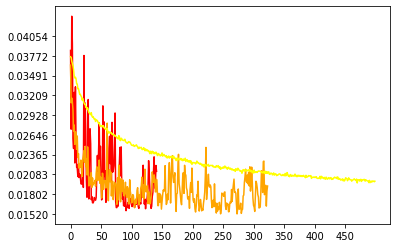

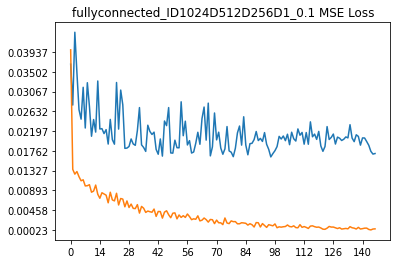

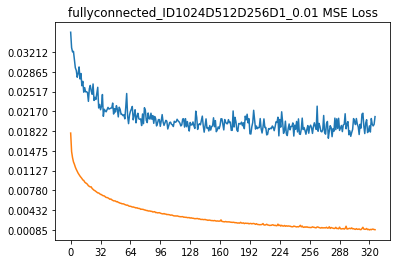

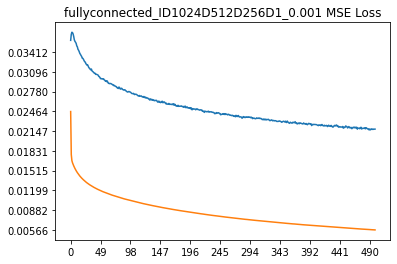

minY  0.0162867121398448
maxY  0.0437140949070453
layers [('Input', 21504), ('Dense', 2048), ('Dense', 1024), ('Dense', 512), ('Dense', 256), ('Dense', 1)]
modelname  fullyconnected_ID2048D1024D512D256D1_0.1
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 2048)              44042240  
_________________________________________________________________
dense_118 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_119 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_120 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 257       
Total params: 46,796,801
Trainable params: 

Epoch 67/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0270
Epoch 68/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0202
Epoch 69/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0244
Epoch 70/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0228
Epoch 71/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0201
Epoch 72/500
14/14 [==============================] - 0s 29ms/step - loss: 8.5697e-04 - val_loss: 0.0174
Epoch 73/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 74/500
14/14 [==============================] - 0s 28ms/step - loss: 9.1958e-04 - val_loss: 0.0186
Epoch 75/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0177
Epoch 76/500
14/14 [==============================] - 0s 28ms/step - loss: 8.1399e-

Epoch 1/500
14/14 [==============================] - 1s 47ms/step - loss: 0.0182 - val_loss: 0.0364
Epoch 2/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0149 - val_loss: 0.0339
Epoch 3/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0139 - val_loss: 0.0324
Epoch 4/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0131 - val_loss: 0.0327
Epoch 5/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0312
Epoch 6/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0299
Epoch 7/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0115 - val_loss: 0.0291
Epoch 8/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0112 - val_loss: 0.0281
Epoch 9/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0108 - val_loss: 0.0284
Epoch 10/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0106 - val_loss: 0.0295

14/14 [==============================] - 0s 28ms/step - loss: 0.0037 - val_loss: 0.0193
Epoch 83/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0188
Epoch 84/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0036 - val_loss: 0.0203
Epoch 85/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0036 - val_loss: 0.0200
Epoch 86/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 0.0203
Epoch 87/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0035 - val_loss: 0.0211
Epoch 88/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0035 - val_loss: 0.0195
Epoch 89/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0199
Epoch 90/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0199
Epoch 91/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0035 - val_loss: 0.0197
Epo

14/14 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0209
Epoch 163/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0198
Epoch 164/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0193
Epoch 165/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0018 - val_loss: 0.0168
Epoch 166/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 167/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0216
Epoch 168/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0223
Epoch 169/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0213
Epoch 170/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0210
Epoch 171/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0167
Epoch 243/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0174
Epoch 244/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0163
Epoch 245/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0184
Epoch 246/500
14/14 [==============================] - 0s 28ms/step - loss: 9.8953e-04 - val_loss: 0.0183
Epoch 247/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0158
Epoch 248/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0166
Epoch 249/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0210
Epoch 250/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 251/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0010 - val_los

14/14 [==============================] - 0s 28ms/step - loss: 0.0145 - val_loss: 0.0347
Epoch 18/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0144 - val_loss: 0.0345
Epoch 19/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0143 - val_loss: 0.0343
Epoch 20/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0142 - val_loss: 0.0341
Epoch 21/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0141 - val_loss: 0.0341
Epoch 22/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0140 - val_loss: 0.0339
Epoch 23/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0139 - val_loss: 0.0337
Epoch 24/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0138 - val_loss: 0.0335
Epoch 25/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0137 - val_loss: 0.0334
Epoch 26/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0136 - val_loss: 0.0332
Epo

14/14 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0280
Epoch 99/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0279
Epoch 100/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0279
Epoch 101/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0278
Epoch 102/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0102 - val_loss: 0.0278
Epoch 103/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0102 - val_loss: 0.0277
Epoch 104/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 0.0278
Epoch 105/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 0.0276
Epoch 106/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0101 - val_loss: 0.0276
Epoch 107/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0101 - val_loss: 0.

14/14 [==============================] - 0s 29ms/step - loss: 0.0086 - val_loss: 0.0255
Epoch 179/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0086 - val_loss: 0.0255
Epoch 180/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0255
Epoch 181/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0255
Epoch 182/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0254
Epoch 183/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0254
Epoch 184/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0254
Epoch 185/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0253
Epoch 186/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0.0254
Epoch 187/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0084 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.0237
Epoch 259/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0238
Epoch 260/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0239
Epoch 261/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0238
Epoch 262/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 263/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0238
Epoch 264/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0073 - val_loss: 0.0237
Epoch 265/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0073 - val_loss: 0.0236
Epoch 266/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0072 - val_loss: 0.0237
Epoch 267/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0072 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 339/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0225
Epoch 340/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0225
Epoch 341/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 342/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 343/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 344/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 345/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 346/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0225
Epoch 347/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0063 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 419/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 420/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0219
Epoch 421/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 422/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0217
Epoch 423/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 424/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0219
Epoch 425/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 426/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 427/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0057 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0213
Epoch 499/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0212
Epoch 500/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0051 - val_loss: 0.0213
Spearmans correlation coefficient: 0.751
Samples are correlated (reject H0) p=0.000


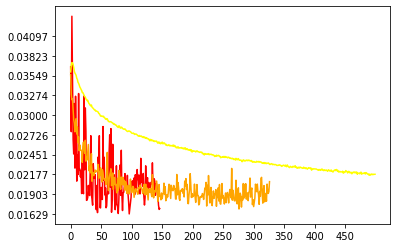

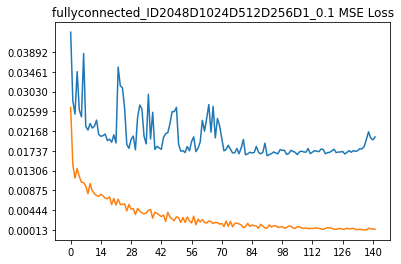

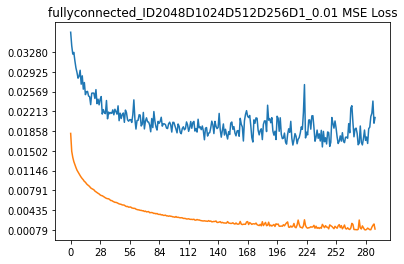

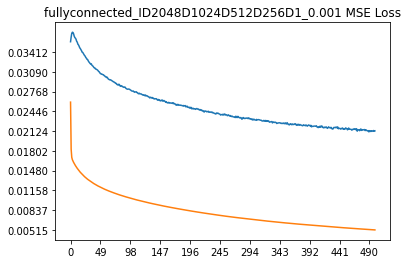

minY  0.01572454161942
maxY  0.0432315692305564
layers [('Input', 21504), ('Dense', 1024), ('Dense', 512), ('Dense', 256), ('Dense', 128), ('Dense', 1)]
modelname  fullyconnected_ID1024D512D256D128D1_0.1
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 1024)              22021120  
_________________________________________________________________
dense_133 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_134 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_135 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 129       
Total params: 22,710,273
Trainable params: 22,7

Epoch 67/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0170
Epoch 68/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0169
Epoch 69/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0171
Epoch 70/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0217
Epoch 71/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0202
Epoch 72/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0228
Epoch 73/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0166
Epoch 74/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0184
Epoch 75/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0019 - val_loss: 0.0166
Epoch 76/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0011 - val_los

Epoch 1/500
14/14 [==============================] - 1s 52ms/step - loss: 0.0175 - val_loss: 0.0379
Epoch 2/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0155 - val_loss: 0.0353
Epoch 3/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0142 - val_loss: 0.0331
Epoch 4/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0133 - val_loss: 0.0332
Epoch 5/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0127 - val_loss: 0.0312
Epoch 6/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0122 - val_loss: 0.0300
Epoch 7/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0117 - val_loss: 0.0288
Epoch 8/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0114 - val_loss: 0.0281
Epoch 9/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0111 - val_loss: 0.0281
Epoch 10/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0108 - val_loss: 0.0293

14/14 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0190
Epoch 83/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0042 - val_loss: 0.0192
Epoch 84/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0210
Epoch 85/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0040 - val_loss: 0.0203
Epoch 86/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0039 - val_loss: 0.0200
Epoch 87/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 0.0209
Epoch 88/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0040 - val_loss: 0.0198
Epoch 89/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.0201
Epoch 90/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.0196
Epoch 91/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 0.0197
Epo

14/14 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0200
Epoch 163/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0198
Epoch 164/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0198
Epoch 165/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0174
Epoch 166/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0209
Epoch 167/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0201
Epoch 168/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0021 - val_loss: 0.0187
Epoch 169/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0195
Epoch 170/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0205
Epoch 171/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0

14/14 [==============================] - 0s 19ms/step - loss: 0.0180 - val_loss: 0.0407
Epoch 4/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0177 - val_loss: 0.0402
Epoch 5/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0174 - val_loss: 0.0398
Epoch 6/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0171 - val_loss: 0.0394
Epoch 7/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0169 - val_loss: 0.0389
Epoch 8/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0166 - val_loss: 0.0385
Epoch 9/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0164 - val_loss: 0.0382
Epoch 10/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0162 - val_loss: 0.0380
Epoch 11/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0160 - val_loss: 0.0376
Epoch 12/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0158 - val_loss: 0.0374
Epoch 13/

14/14 [==============================] - 0s 23ms/step - loss: 0.0110 - val_loss: 0.0288
Epoch 85/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0110 - val_loss: 0.0288
Epoch 86/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0110 - val_loss: 0.0286
Epoch 87/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0286
Epoch 88/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0285
Epoch 89/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0285
Epoch 90/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0108 - val_loss: 0.0285
Epoch 91/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0108 - val_loss: 0.0284
Epoch 92/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0108 - val_loss: 0.0283
Epoch 93/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0108 - val_loss: 0.0282
Epo

14/14 [==============================] - 0s 20ms/step - loss: 0.0092 - val_loss: 0.0258
Epoch 165/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0091 - val_loss: 0.0258
Epoch 166/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0258
Epoch 167/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0258
Epoch 168/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0091 - val_loss: 0.0258
Epoch 169/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0091 - val_loss: 0.0257
Epoch 170/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0091 - val_loss: 0.0258
Epoch 171/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0090 - val_loss: 0.0257
Epoch 172/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0090 - val_loss: 0.0257
Epoch 173/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0090 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0079 - val_loss: 0.0242
Epoch 245/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0079 - val_loss: 0.0242
Epoch 246/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0079 - val_loss: 0.0242
Epoch 247/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0079 - val_loss: 0.0240
Epoch 248/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0079 - val_loss: 0.0241
Epoch 249/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0.0241
Epoch 250/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0.0242
Epoch 251/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0.0241
Epoch 252/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0078 - val_loss: 0.0242
Epoch 253/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0078 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 325/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 326/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0231
Epoch 327/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 328/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 329/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 330/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 331/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 332/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.0230
Epoch 333/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0

14/14 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0224
Epoch 405/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0222
Epoch 406/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0063 - val_loss: 0.0221
Epoch 407/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0222
Epoch 408/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0222
Epoch 409/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0222
Epoch 410/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 411/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0221
Epoch 412/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 413/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0

14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0216
Epoch 485/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0217
Epoch 486/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0216
Epoch 487/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0216
Epoch 488/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0215
Epoch 489/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0215
Epoch 490/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0214
Epoch 491/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0216
Epoch 492/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0214
Epoch 493/500
14/14 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0

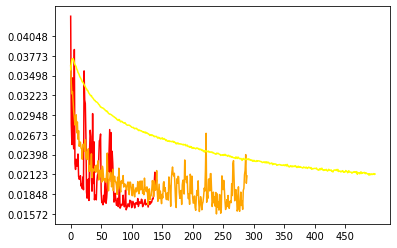

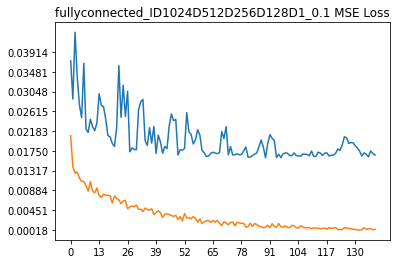

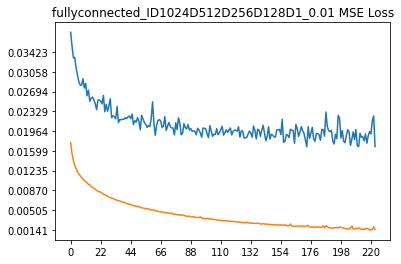

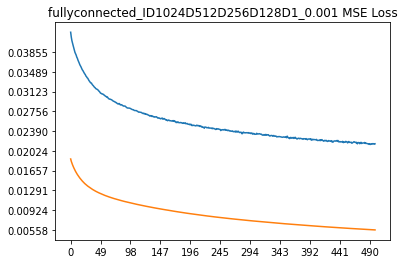

minY  0.0159602500498294
maxY  0.0434718318283557
layers [('Input', 21504), ('Dense', 2048), ('Dense', 1024), ('Dense', 512), ('Dense', 256), ('Dense', 128), ('Dense', 1)]
modelname  fullyconnected_ID2048D1024D512D256D128D1_0.1
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 2048)              44042240  
_________________________________________________________________
dense_148 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_149 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_150 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_151 (Dense)            (None, 128)               32896     
_______________________

14/14 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0265
Epoch 66/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0231
Epoch 67/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0025 - val_loss: 0.0253
Epoch 68/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0195
Epoch 69/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0259
Epoch 70/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0224
Epoch 71/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 72/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 73/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 74/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0277
Epo

Epoch 1/500
14/14 [==============================] - 1s 56ms/step - loss: 0.0187 - val_loss: 0.0386
Epoch 2/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0162 - val_loss: 0.0367
Epoch 3/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0152 - val_loss: 0.0354
Epoch 4/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0143 - val_loss: 0.0353
Epoch 5/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0137 - val_loss: 0.0337
Epoch 6/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0131 - val_loss: 0.0324
Epoch 7/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0126 - val_loss: 0.0309
Epoch 8/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0122 - val_loss: 0.0299
Epoch 9/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0118 - val_loss: 0.0309
Epoch 10/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0114 - val_loss: 0.0311

14/14 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0206
Epoch 83/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0193
Epoch 84/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0217
Epoch 85/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 0.0214
Epoch 86/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0213
Epoch 87/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0037 - val_loss: 0.0214
Epoch 88/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0037 - val_loss: 0.0197
Epoch 89/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0036 - val_loss: 0.0202
Epoch 90/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0037 - val_loss: 0.0203
Epoch 91/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 0.0206
Epo

14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0224
Epoch 163/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 0.0219
Epoch 164/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0019 - val_loss: 0.0194
Epoch 165/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0170
Epoch 166/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0203
Epoch 167/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0025 - val_loss: 0.0259
Epoch 168/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0030 - val_loss: 0.0234
Epoch 169/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0223
Epoch 170/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0214
Epoch 171/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0171
Epoch 243/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0175
Epoch 244/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 245/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0013 - val_loss: 0.0188
Epoch 246/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0010 - val_loss: 0.0177
Epoch 247/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0029 - val_loss: 0.0165
Epoch 248/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0019 - val_loss: 0.0172
Epoch 249/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0018 - val_loss: 0.0210
Epoch 250/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0010 - val_loss: 0.0196
Epoch 251/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0010 - val_loss: 0

Epoch 9/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0169 - val_loss: 0.0389
Epoch 10/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0168 - val_loss: 0.0388
Epoch 11/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0166 - val_loss: 0.0386
Epoch 12/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0165 - val_loss: 0.0384
Epoch 13/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0164 - val_loss: 0.0382
Epoch 14/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0162 - val_loss: 0.0380
Epoch 15/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0161 - val_loss: 0.0378
Epoch 16/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0160 - val_loss: 0.0376
Epoch 17/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0159 - val_loss: 0.0374
Epoch 18/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0158 - val_loss

14/14 [==============================] - 0s 29ms/step - loss: 0.0115 - val_loss: 0.0303
Epoch 91/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0114 - val_loss: 0.0302
Epoch 92/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0114 - val_loss: 0.0301
Epoch 93/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0114 - val_loss: 0.0301
Epoch 94/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0113 - val_loss: 0.0300
Epoch 95/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0113 - val_loss: 0.0299
Epoch 96/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0113 - val_loss: 0.0299
Epoch 97/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0112 - val_loss: 0.0299
Epoch 98/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0112 - val_loss: 0.0298
Epoch 99/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0112 - val_loss: 0.0298
Epo

14/14 [==============================] - 0s 29ms/step - loss: 0.0094 - val_loss: 0.0271
Epoch 171/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0094 - val_loss: 0.0269
Epoch 172/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0094 - val_loss: 0.0269
Epoch 173/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0093 - val_loss: 0.0268
Epoch 174/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0093 - val_loss: 0.0267
Epoch 175/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0093 - val_loss: 0.0268
Epoch 176/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0093 - val_loss: 0.0267
Epoch 177/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0093 - val_loss: 0.0268
Epoch 178/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0092 - val_loss: 0.0266
Epoch 179/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0092 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 251/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0250
Epoch 252/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 253/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0250
Epoch 254/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 255/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0079 - val_loss: 0.0250
Epoch 256/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0079 - val_loss: 0.0250
Epoch 257/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0079 - val_loss: 0.0250
Epoch 258/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0079 - val_loss: 0.0249
Epoch 259/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0079 - val_loss: 0

14/14 [==============================] - 0s 30ms/step - loss: 0.0070 - val_loss: 0.0238
Epoch 331/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0070 - val_loss: 0.0239
Epoch 332/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0070 - val_loss: 0.0237
Epoch 333/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0070 - val_loss: 0.0238
Epoch 334/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0070 - val_loss: 0.0238
Epoch 335/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0069 - val_loss: 0.0237
Epoch 336/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0069 - val_loss: 0.0237
Epoch 337/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0069 - val_loss: 0.0238
Epoch 338/500
14/14 [==============================] - 0s 30ms/step - loss: 0.0069 - val_loss: 0.0237
Epoch 339/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0069 - val_loss: 0

14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0230
Epoch 411/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 412/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0230
Epoch 413/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0231
Epoch 414/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0229
Epoch 415/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 416/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0062 - val_loss: 0.0227
Epoch 417/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0229
Epoch 418/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0061 - val_loss: 0.0228
Epoch 419/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0

14/14 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0220
Epoch 491/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0222
Epoch 492/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0220
Epoch 493/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0221
Epoch 494/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0055 - val_loss: 0.0222
Epoch 495/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0221
Epoch 496/500
14/14 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0222
Epoch 497/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0055 - val_loss: 0.0222
Epoch 498/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0055 - val_loss: 0.0222
Epoch 499/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0055 - val_loss: 0

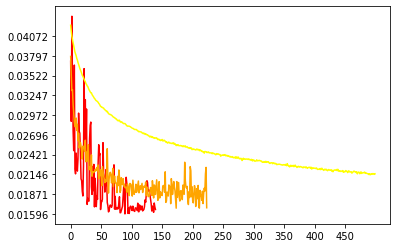

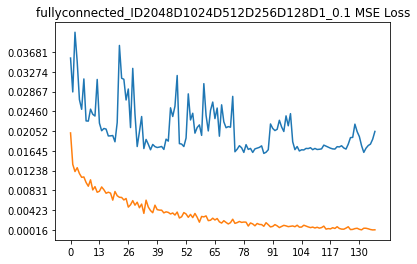

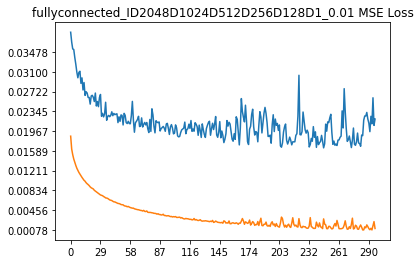

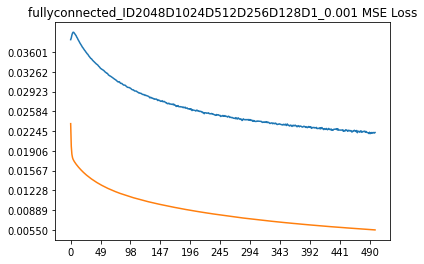

minY  0.0159247014671564
maxY  0.0408868305385112


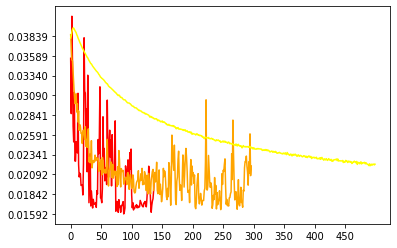

In [10]:
def main():
    loadData()
    
    structureConfigs = [ [2048, 1024], [1024, 512], [2048, 512], [1024, 256], 
                        [1024,12], [512,24], [256,48], [128,96], [512, 128],
                      [2048, 1024, 512], [2048, 1024, 256], [1024, 512, 256],
                      [2048, 1024, 512, 256], [1024, 512, 256, 128],
                      [2048, 1024, 512, 256, 128] ]
    #layers = [('Input', 3072), ('Dense', 1024), ('Dropout', 0.5), ('Dense', 256), ('Dense', 1)]
    for structureConfig in structureConfigs:
        layers = constructStructure(structureConfig)
        tryLayerStructure(layers)

main()